## Import all the required Modules

In [19]:
import numpy as np
import xarray as xr
from tqdm import tqdm
import torch
import gpytorch
import os

import sys
sys.path.append('../src/gpytorch/')
import utilities as rsutil
import frameworkWgpu as rsframe

## Load the Data

In [3]:
datafolder = '../Resources/'
# Precipitation in mm/day
cmip6_monthly = xr.open_dataset('{}cmip6_5x5interpolated_global.nc'\
                        .format(datafolder)).dropna('lat')*86400
# Make sure there is no zero values
pannual = cmip6_monthly.groupby('time.year').mean('time')
pannual = pannual.where(pannual>0).fillna(1e-10)
pr5yr = rsutil.preprocess_5year(np.log(pannual))

## Temporal Gaussian Process Regression to Predict the Emergence of Future Precipitation

In [4]:
class temporalGCMMean(gpytorch.means.Mean):
    '''
    Takes in the prior values for the training and prediction datasets
    and returns the multimodel mean values when called.
    '''
    def __init__(self, y, y_star):
        super(temporalGCMMean, self).__init__()
        self.mmm = y.mean(dim=0)
        self.mmm_star = y_star.mean(dim=0)
        self.n = y.size()[1]
        self.n_star = y_star.size()[1]

    def refit(self, y, y_star):
        self.mmm = y.mean(dim=0)
        self.mmm_star = y_star.mean(dim=0)
        self.n = y.size()[1]
        self.n_star = y_star.size()[1]
        
    def forward(self, input):
        if input.size()[0] == self.n:
            return self.mmm
        elif input.size()[0] == self.n+self.n_star:
            return torch.cat((self.mmm,self.mmm_star))
        else:
            print(input)
            print('Check the GCM mean module')

class temporalGCMCovar(gpytorch.kernels.Kernel):
    '''
    The class for calculating the prior covaraince matrices. 
    Takes in the prior values for the training and prediction periods 
    from all the other GCMs and returns the 
    prior covariance matrices when called.
    '''
    is_stationary = False
    def __init__(self, y, y_star, **kwargs):
        super(temporalGCMCovar, self).__init__(**kwargs)
        self.gcmcov = torch.cov(torch.cat([y.T,y_star.T]))
        self.n = y.size()[1]
        self.n_star = y_star.size()[1]

    def refit(self, y, y_star):
        self.gcmcov = torch.cov(torch.cat([y.T,y_star.T]))
        self.n = y.size()[1]
        self.n_star = y_star.size()[1]
        
    # this is the kernel function
    def forward(self, x1, x2,**kwargs):
        if (x1.size()[0]==self.n)&(x2.size()[0]==self.n):
            return self.gcmcov[:self.n,:self.n]
        elif (x1.size()[0]==self.n_star)&(x2.size()[0]==self.n+self.n_star):
            return self.gcmcov[self.n:,:]
        else:
            print('Check the GCM covariance module')

class temporalGPModel(gpytorch.models.ExactGP):
    '''
    This class defines the heart of GPR. It defines the kernel, prior means 
    and covariances.
    '''
    def __init__(self, train_x, train_y, prior_x, prior_y, prior_ys, likelihood):
        super(temporalGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = temporalGCMMean(prior_y, prior_ys)
        self.covar_gcm = temporalGCMCovar(prior_y, prior_ys)
        # Defining the GPR kernel
        self.covar_module = gpytorch.kernels.ScaleKernel(\
                    gpytorch.kernels.MaternKernel())+self.covar_gcm
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Test on one Model at one Location

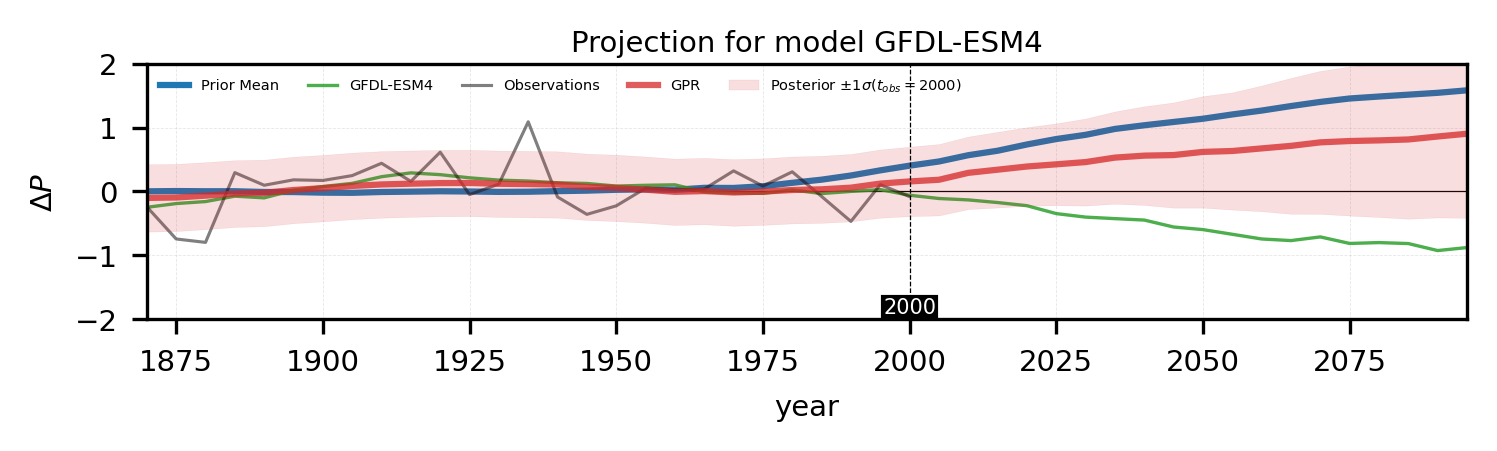

In [5]:
# Training period for the GPR
training_period = slice(1870,2000)
# Reference period for observational noise estimation
ref_period = slice(1870,1970)
# Location for which the regression is implemented
loc = [20, -5]
# Selected out of sample model
oosm_index = 19
models = pr5yr[0]['models'].values
oos_model = models[oosm_index]
other_gcms = list(set(models)-set({oos_model}))
# Observations 
oos_gcm = pr5yr[1]['pr'].sel(models=oos_model,\
                        lon=loc[0],lat=loc[1])
# Smoothed values for observations. Used for plotting and error calculations
oos_gcm_smoothed = pr5yr[0]['pr'].sel(models=oos_model,\
                        lon=loc[0],lat=loc[1])
# Priors from smoothed values
other_gcms_smoothed = pr5yr[0]['pr'].sel(models=other_gcms,\
                        lon=loc[0],lat=loc[1]).transpose('models','year')
# Define GPR model
ugpr = rsframe.temporalGPR(oos_gcm, oos_gcm_smoothed,\
                           other_gcms_smoothed, ref_period)
ugpr.initialize_model(temporalGPModel, training_period)
# Train the model
ugpr.train_model(50)
ugpr.predict()
rsutil.plot_predicted(ugpr,'nstd',False)

#### Add more data and predict

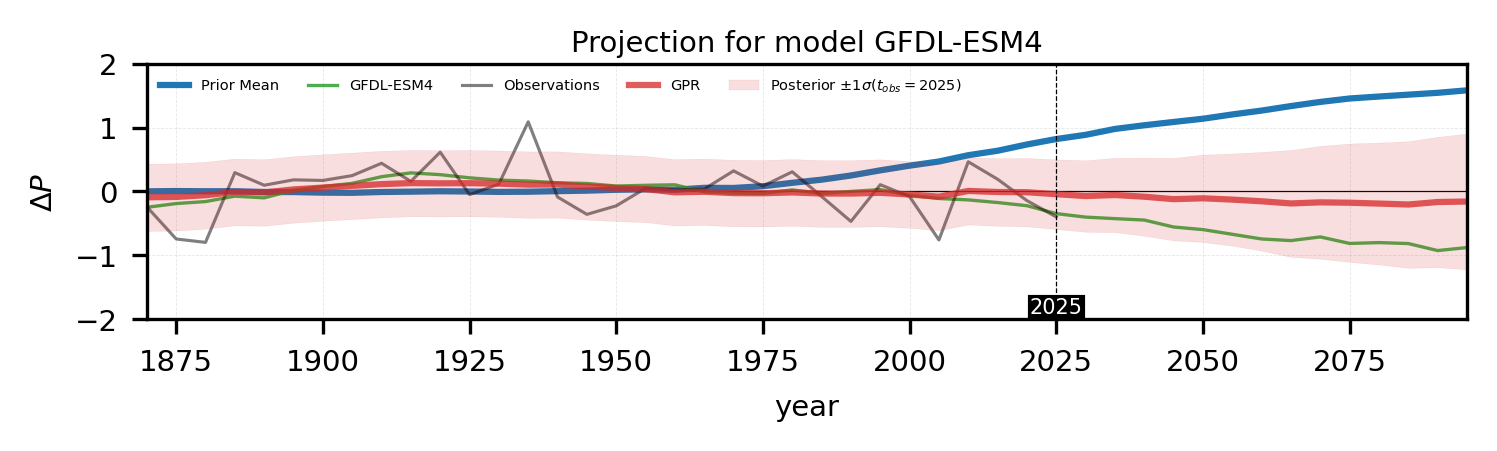

In [7]:
ugpr.fit(slice(1870,2025))
ugpr.predict()
rsutil.plot_predicted(ugpr,'nstd', False)

#### Calculate Emergence

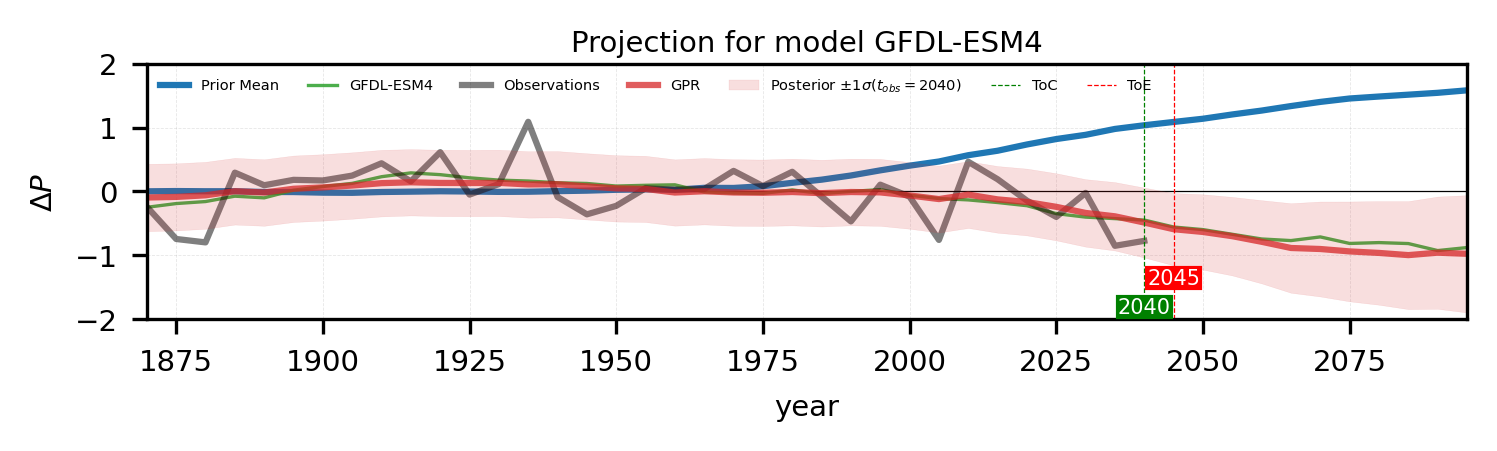

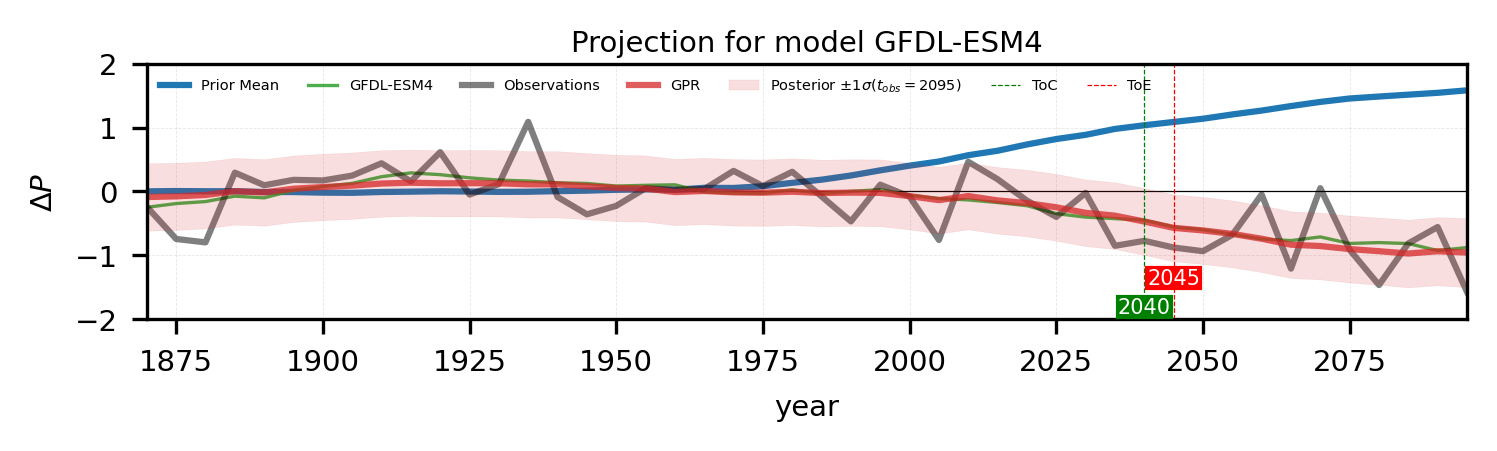

In [8]:
with gpytorch.settings.debug(state=False):
    ugpr.calculate_emergence(1990, 1, .75, 'nstd')
rsutil.plot_emergence_on_toc(ugpr, 'nstd',False)
rsutil.plot_emergence(ugpr, 'nstd',False)

#### Validation for the location

In [9]:
ts = [2000, 2020, 2040]
vals,preds = rsutil.validate_posterior(ugpr, 'nstd', ts)

In [10]:
vals

<xarray.Dataset> Size: 232B
Dimensions:     (tobs: 3)
Coordinates:
    lat         int64 8B -5
    models      <U16 64B 'GFDL-ESM4'
    lon         int64 8B 20
  * tobs        (tobs) int64 24B 2000 2020 2040
    year        int64 8B 2075
Data variables:
    mu_star     (tobs) float64 24B 1.461 0.6834 0.01178
    mu          (tobs) float64 24B 0.007682 0.01223 0.005004
    i68         (tobs) float64 24B 0.35 0.4375 0.8333
    i95         (tobs) float64 24B 1.0 1.0 1.0
    mean_error  (tobs) float64 24B 1.603 1.003 -0.1247

### Spatiotemporal Gaussian Process Regression of predicting the emergence of future Precipitation

In [11]:
class spacetimeGCMMean(gpytorch.means.Mean):
    '''
    The class for calculating the prior mean. 
    Takes in the prior values from all the other GCMs and returns the 
    multimodel means when called.
    '''
    def __init__(self, y, y_star):
        super(spacetimeGCMMean, self).__init__()
        self.mmm = y.mean(dim=0)
        self.mmm_star = y_star.mean(dim=0)
        self.n = y.size()[1]
        self.n_star = y_star.size()[1]
        
    def refit(self, y, y_star):
        self.mmm = y.mean(dim=0)
        self.mmm_star = y_star.mean(dim=0)
        self.n = y.size()[1]
        self.n_star = y_star.size()[1]
        
    def forward(self, input):
        if input.size()[0] == self.n:
            return self.mmm
        elif input.size()[0] == self.n+self.n_star:
            return torch.cat((self.mmm,self.mmm_star))
        else:
            print(input)
            print('Check the GCM mean module')


class spacetimeGCMCovar(gpytorch.kernels.Kernel):
    '''
    The class for calculating the prior covaraince matrices. 
    Takes in the prior values from all the other GCMs and returns the 
    prior covariance matrices when called.
    '''
    is_stationary = False
    def __init__(self, y, y_star, **kwargs):
        super(spacetimeGCMCovar, self).__init__(**kwargs)
        self.gcmcov = torch.cov(torch.cat([y.T,y_star.T]))
        self.n = y.size()[1]
        self.n_star = y_star.size()[1]

    def refit(self, y, y_star):
        self.gcmcov = torch.cov(torch.cat([y.T,y_star.T]))
        self.n = y.size()[1]
        self.n_star = y_star.size()[1]
        
    # this is the kernel function
    def forward(self, x1, x2,**kwargs):
        if (x1.size()[0]==self.n)&(x2.size()[0]==self.n):
            return self.gcmcov[:self.n,:self.n]
        elif (x1.size()[0]==self.n_star)&(x2.size()[0]==self.n_star):
            return self.gcmcov[-self.n_star:,-self.n_star:]
        elif (x1.size()[0]==self.n_star)&(x2.size()[0]==self.n):
            return self.gcmcov[-self.n_star:,:self.n]
        else:
            print('Check the GCM covariance module')


class spacetimeGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, prior_x, prior_y, prior_ys, likelihood):
        super(spacetimeGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = spacetimeGCMMean(prior_y, prior_ys)
        self.space_kernel = gpytorch.kernels.MaternKernel(ard_num_dims=2,active_dims=torch.tensor([1,2]))
        self.time_kernel = gpytorch.kernels.LinearKernel(ard_num_dims=1,active_dims=torch.tensor([0]))
        # self.time_kernel = gpytorch.kernels.MaternKernel(nu=2.5,ard_num_dims=1,active_dims=torch.tensor([0]))
        
        self.gcm_covar = spacetimeGCMCovar(prior_y, prior_ys)
        # self.base_kernel = gpytorch.kernels.MaternKernel(ard_num_dims=3)
        # self.covar_module = self.base_kernel+self.gcm_covar
        # self.covar_module = self.time_kernel*gpytorch.kernels.ScaleKernel(self.space_kernel)\
        #                         +self.gcm_covar
        self.covar_module = self.time_kernel\
                            *gpytorch.kernels.ScaleKernel(self.space_kernel)\
                            +self.gcm_covar
                            

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

/Users/an1009/miniconda3/envs/pytor/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:20: UserWarning: The operator 'aten::linalg_cholesky_ex.L' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_19qm5ghvuj/croot/libtorch_1736268753361/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  L, info = torch.linalg.cholesky_ex(A, out=out)


2.87 s ± 240 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


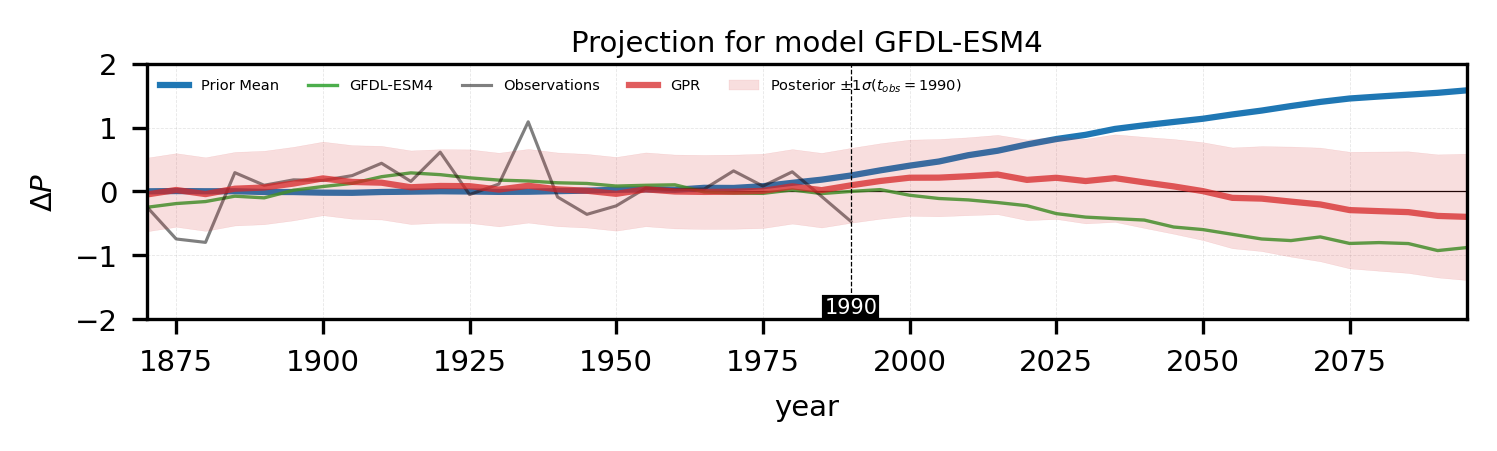

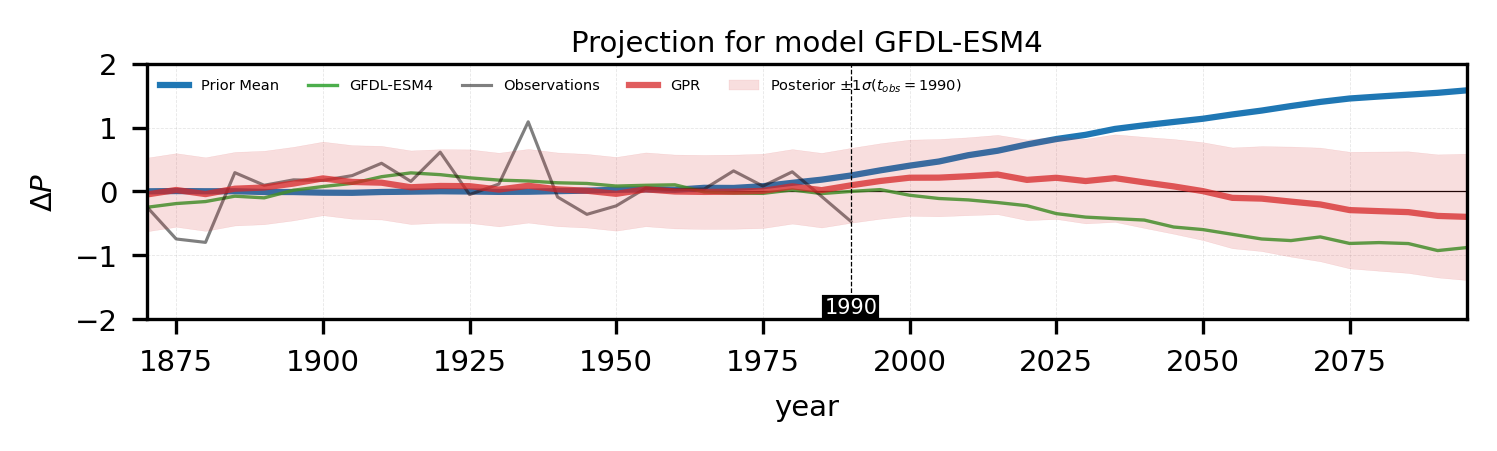

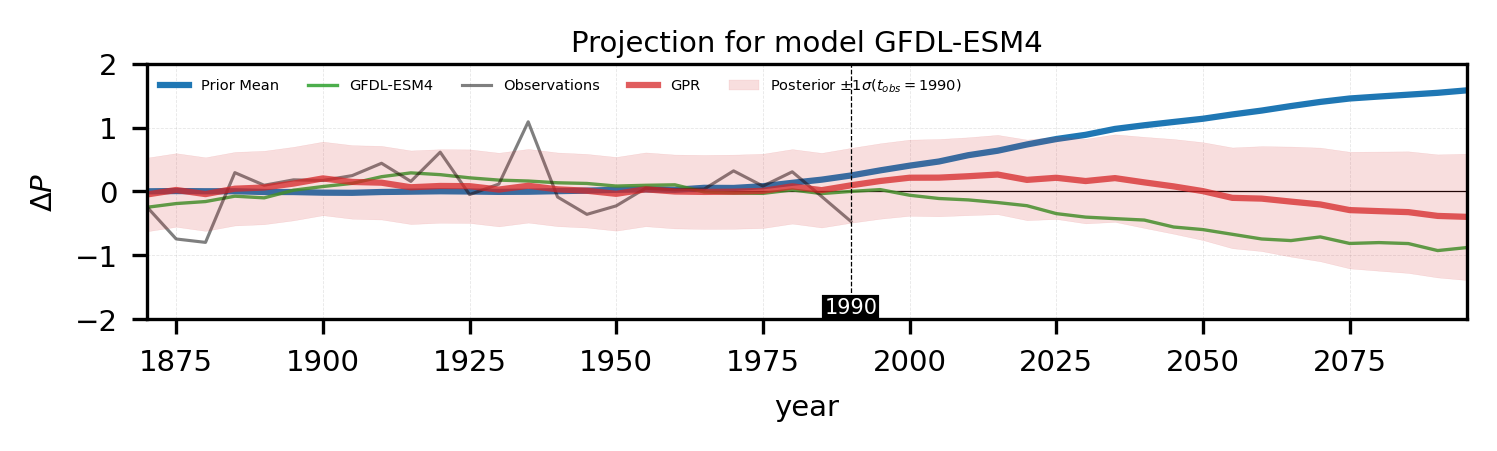

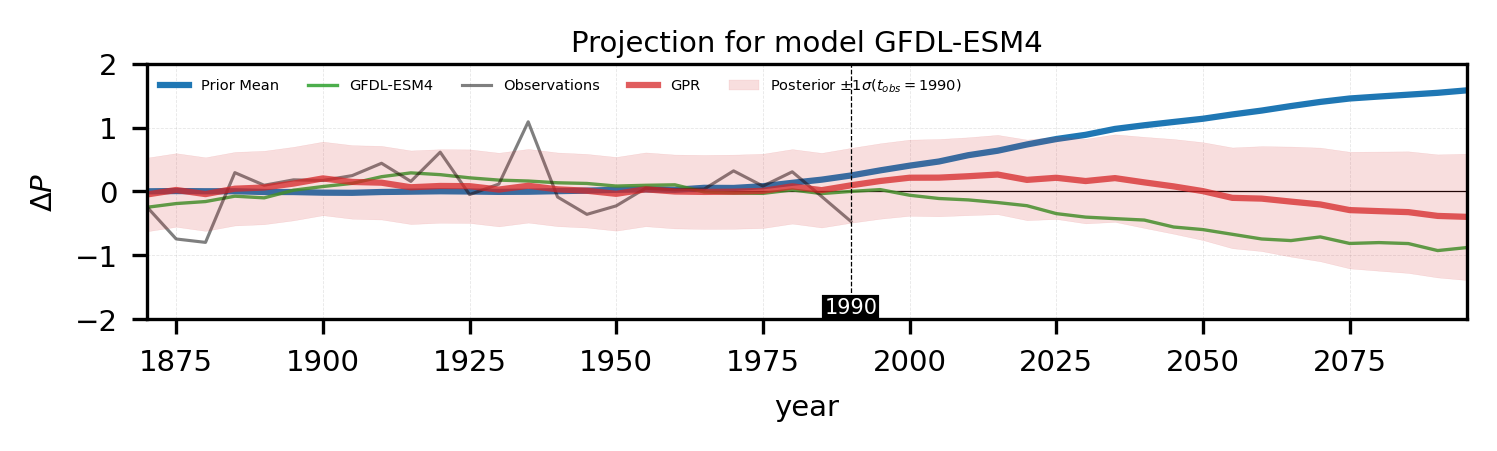

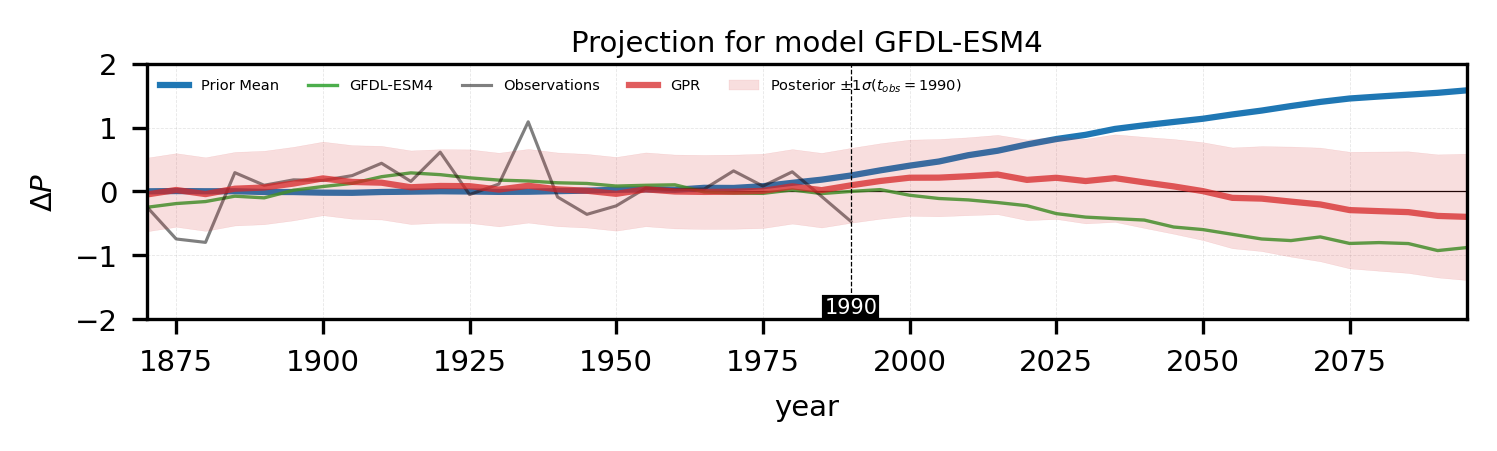

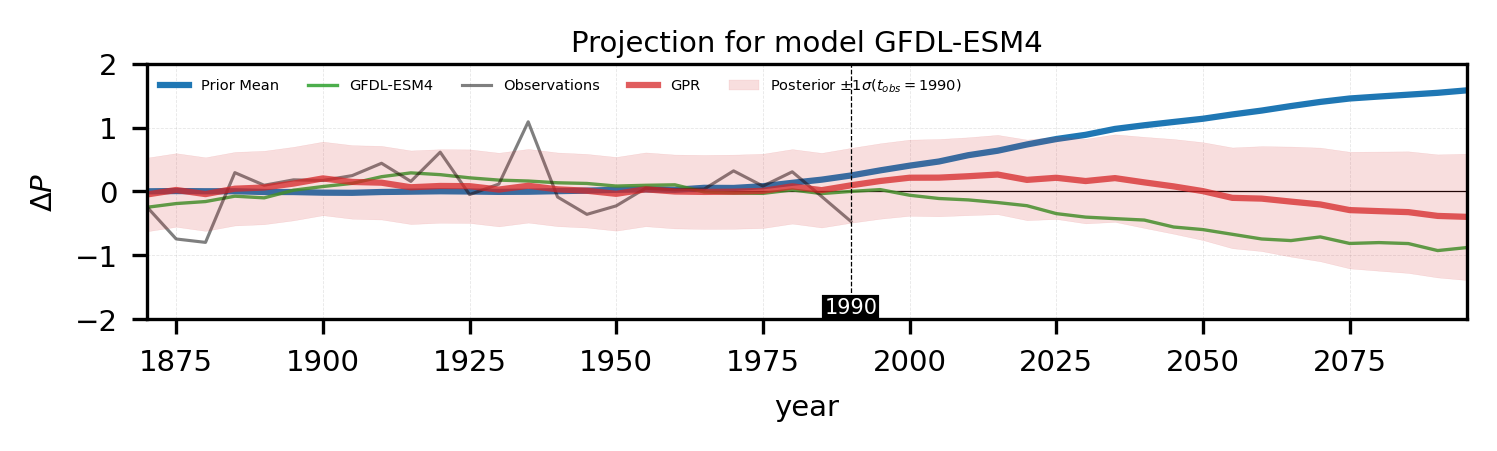

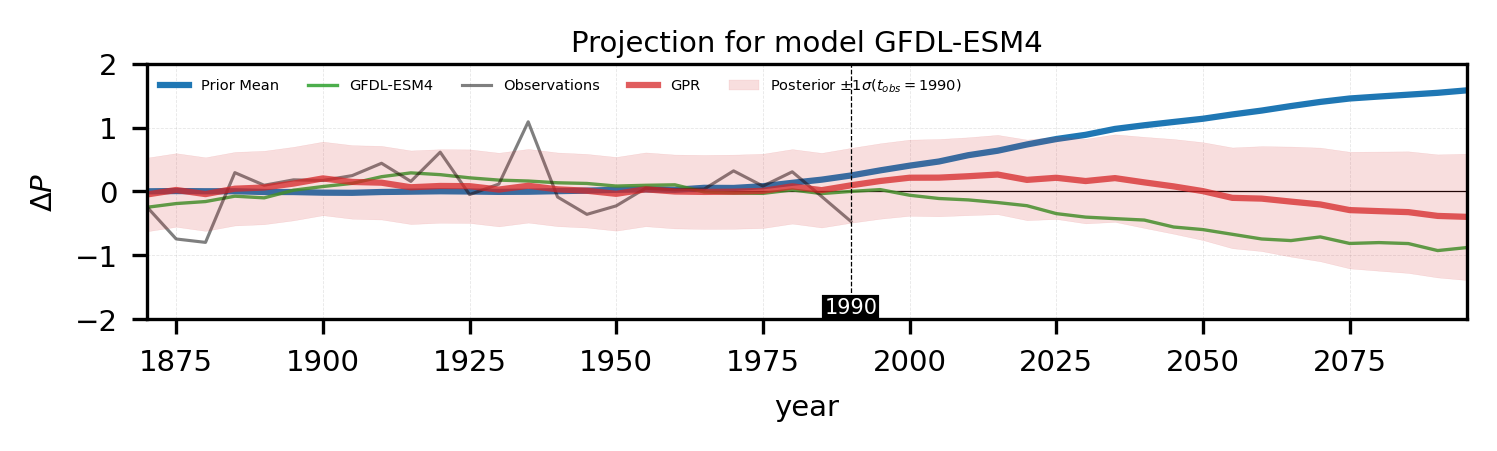

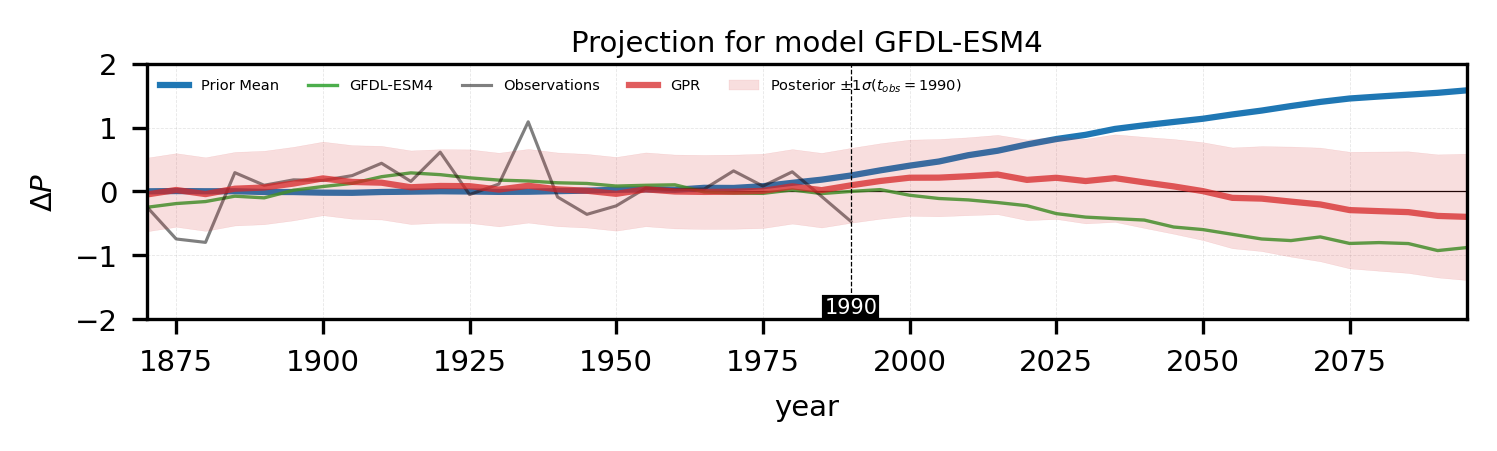

In [20]:
%%timeit
wsize = 11
slat = -5
slon = 20
oosm_index = 19

models = pr5yr[0]['models'].values
oos_model = models[oosm_index]
other_gcms = list(set(models)-set({oos_model}))

oos_gcm = pr5yr[1]['pr'].sel(models=oos_model,\
                lat=slice(slat-wsize,slat+wsize),\
                lon=slice(slon-wsize,slon+wsize))\
                .transpose('year','lon','lat')
oos_gcm_smoothed = pr5yr[0]['pr'].sel(models=oos_model,\
                lat=slice(slat-wsize,slat+wsize),\
                lon=slice(slon-wsize,slon+wsize))\
                .transpose('year','lon','lat')
other_gcms_smoothed = pr5yr[0]['pr'].sel(models=other_gcms,\
                    lat=slice(slat-wsize,slat+wsize),\
                     lon=slice(slon-wsize,slon+wsize))\
                    .transpose('models','year','lon','lat')
# Training period for the GPR
training_period = slice(1870,1990)
# Reference period for the observational noise
reference_period = slice(1870,1970)
# Define the GPR model
mgpr = rsframe.spacetimeGPR(oos_gcm, oos_gcm_smoothed, other_gcms_smoothed,\
                    reference_period, slon, slat, wsize)
mgpr.initialize_model(spacetimeGPModel, training_period)
mgpr.train_model(50)
mgpr.predict()
rsutil.plot_predicted(mgpr,'nstd',False)

#### Add more data and predict

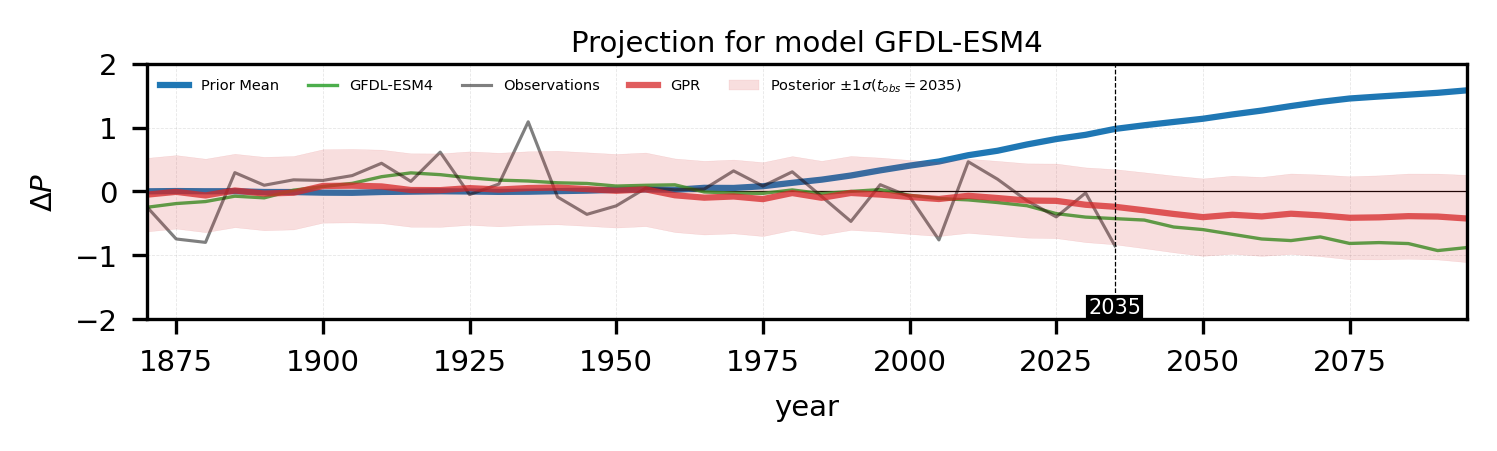

In [14]:
mgpr.fit(slice(1870,2035))
mgpr.predict()
rsutil.plot_predicted(mgpr,'nstd', False)

#### Calculate the Emergence

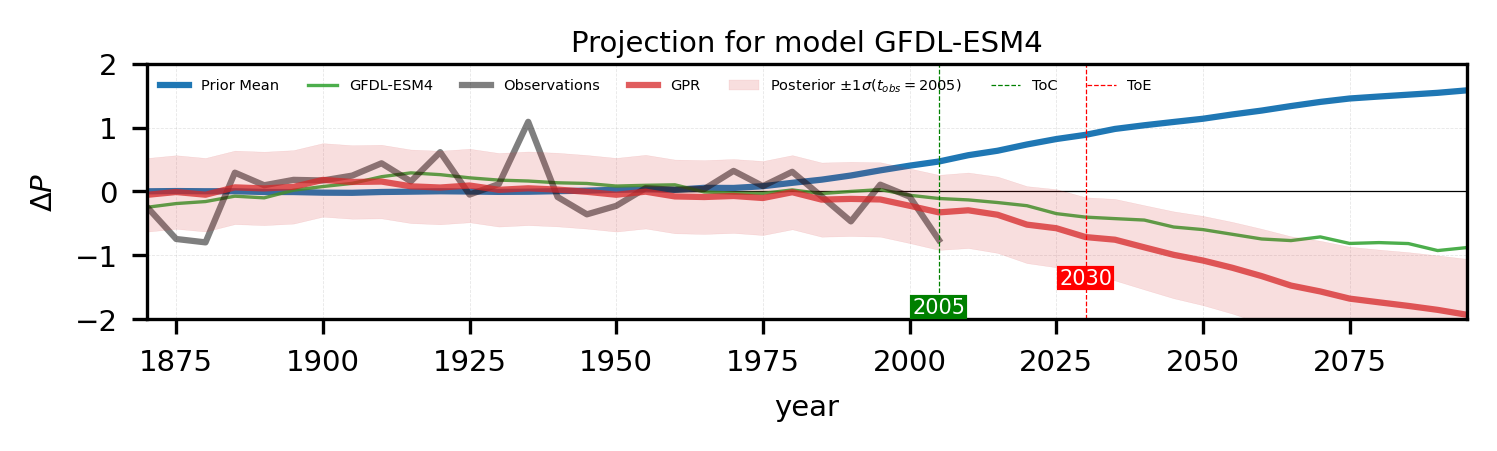

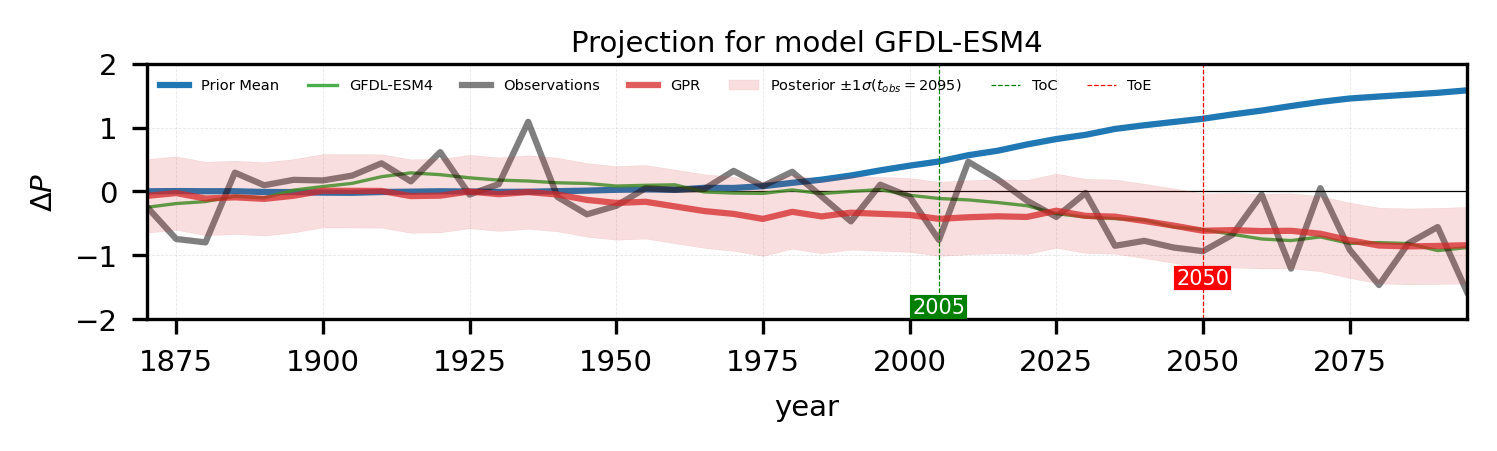

In [15]:
with gpytorch.settings.debug(state=False):
    mgpr.calculate_emergence(1990, 1, .75, 'nstd')
rsutil.plot_emergence_on_toc(mgpr, 'nstd',False)
rsutil.plot_emergence(mgpr, 'nstd',False)

#### Validation for the location

In [16]:
ts = [2000, 2020, 2040]
vals,preds = rsutil.validate_posterior(mgpr, 'nstd', ts)

In [17]:
vals

<xarray.Dataset> Size: 232B
Dimensions:     (tobs: 3)
Coordinates:
    lat         int64 8B -5
    models      <U16 64B 'GFDL-ESM4'
    lon         int64 8B 20
  * tobs        (tobs) int64 24B 2000 2020 2040
    year        int64 8B 2075
Data variables:
    mu_star     (tobs) float64 24B 0.06729 0.003734 0.2524
    mu          (tobs) float64 24B 0.01539 0.01022 0.01971
    i68         (tobs) float64 24B 0.85 0.9375 0.5
    i95         (tobs) float64 24B 1.0 1.0 1.0
    mean_error  (tobs) float64 24B 0.212 0.01665 0.5539